# Fly ash usage model

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/VysokePece1.jpg" width="400">

We want to change the fraction of primary versus recycle steel production over time, and have the fraction of fly ash flowing into concrete production change at the same time.

To accomplish this, we need to create a new steel process (in a new database), which will be a mix of different steel production types.

In [1]:
import bw2data as bd
import bw2calc as bc
import bw2io as bi
import bw_processing as bwp
from dataclasses import dataclass
from typing import Callable
import logging
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt

Change level to `logging.DEBUG` to print too much, `logging.WARNING` to print less

In [2]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('flexible-chains')
logger.setLevel(level=logging.INFO)

In [3]:
bi.restore_project_directory(
    fp="/srv/data/ecoinvent-3.9-cutoff.tar.gz", 
    project_name="♻️💥🔥🔗",
    overwrite_existing=True
)

Restoring project backup archive - this could take a few minutes...


'♻️💥🔥🔗'

In [4]:
bd.projects.set_current("♻️💥🔥🔗")

In [5]:
@dataclass
class Constants:
    steel_market: bd.Node
    cement_market: bd.Node
    slag_process: bd.Node
    mass_fly_ash_per_kilogram_steel: float
    fraction_fly_ash_to_this_cement_market: float
    converter_filter_function: Callable
    electric_filter_function: Callable
    clinker_filter_function: Callable

In [6]:
my_configuration = Constants(
    steel_market = bd.get_node(
        name="market for steel, low-alloyed", 
        location="GLO", 
        database="ecoinvent-3.9-cutoff"
    ),
    cement_market = bd.get_node(
        name="cement production, CEM II/A", 
        location="CH", 
        database="ecoinvent-3.9-cutoff"
    ),
    slag_process = bd.get_node(
        name="ground granulated blast furnace slag production", 
        location="RoW", 
        database="ecoinvent-3.9-cutoff"
    ),
    mass_fly_ash_per_kilogram_steel = 0.0025,  # Fix, total guess
    fraction_fly_ash_to_this_cement_market = 0.5,  # Configurable
    converter_filter_function = lambda x: "converter" in x['name'].lower() and "steel" in x['name'].lower(),
    electric_filter_function = lambda x: "electric" in x['name'].lower() and "steel" in x['name'].lower(),
    clinker_filter_function = lambda x: 'clinker' in x['name'].lower()
)

In [7]:
def get_exchange_production_volume(exchange: bd.Edge) -> float:
    try:
        return exchange.input.rp_exchange()['production volume']
    except:
        return 0.

In [8]:
class BlastOff:
    def __init__(self, configuration):
        self.config = configuration

    def generate_datapackage(
            self, 
            fraction_blast_oven_steel: float, 
    ) -> bwp.Datapackage:
        """Generate a datapackage that will change matrix values based on the given configuration.
        
        Inputs:
        fraction_blast_oven_steel: float
            The fraction of steel which is made from the blast oven (between 0 and 1)
        """
        dp = bwp.create_datapackage()

        assert 0 <= fraction_blast_oven_steel <= 1
        mass_fly_ash = self.calculate_mass_fly_ash(
            fraction_blast_oven_steel, 
        )
        self.adjust_steel_market(fraction_blast_oven_steel, dp)
        self.adjust_cement_market(mass_fly_ash * self.config.fraction_fly_ash_to_this_cement_market, dp)
        return dp

    def adjust_cement_market(self, mass_fly_ash: float, dp: bwp.Datapackage) -> None:
        """Change the relative fraction of all players in `self.config.cement_market`.

        Adds a resource group to `self.dp`."""
        exchanges = [{
            'indices': (exc.input.id, exc.output.id),
            'input': exc.input,
            'original': exc['amount'],
            'pv': get_exchange_production_volume(exc)
        } for exc in self.config.cement_market.technosphere()
        if self.config.clinker_filter_function(exc.input)]
        total_clinker_fraction = sum(o['original'] for o in exchanges)
        total_clinker_pv = sum(o['pv'] for o in exchanges)
        fly_ash_fraction = mass_fly_ash / (total_clinker_pv / total_clinker_fraction)
        assert 0.25 < total_clinker_fraction <= 1

        logger.info(f"Fly ash mass coming into cement market: {mass_fly_ash}")
        logger.info(f"Total clinker fraction before modification: {total_clinker_fraction}")
        logger.info(f"Total clinker PV (kg) before modification: {total_clinker_pv}")

        # Fly ash could already be present. There are also other binders that we
        # don't touch. Can't just multiply, need to be careful
        existing_fly_ash_fraction = sum([
            (exc['amount'] if exc.input == self.config.slag_process else 0)
            for exc in self.config.cement_market.technosphere()
        ])

        reduction_in_clinker = fly_ash_fraction - existing_fly_ash_fraction
        clinker_multiplier = (total_clinker_fraction - reduction_in_clinker) / total_clinker_fraction
        if clinker_multiplier < 0:
            clinker_multiplier = 0

        max_possible_fly_ash = total_clinker_fraction + existing_fly_ash_fraction
        if fly_ash_fraction > max_possible_fly_ash:
            fly_ash_fraction = max_possible_fly_ash

        logger.info(f"Total fly ash fraction before modification: {existing_fly_ash_fraction}")
        logger.info(f"New fly ash fraction: {fly_ash_fraction}")
        logger.info(f"Clinker multiplier: {clinker_multiplier}")

        data, indices = [fly_ash_fraction], [(self.config.slag_process.id, self.config.cement_market.id)]
        for exc in exchanges:
            data.append(exc['original'] * clinker_multiplier)
            logger.info(f"Changing input of {exc['input']} from {exc['original']} to {exc['original'] * clinker_multiplier}")
            indices.append(exc['indices'])

        dp.add_persistent_vector(
            matrix="technosphere_matrix",
            data_array=np.array(data),
            name="cement market clinker substitution",
            indices_array=np.array(indices, dtype=bwp.INDICES_DTYPE),
            flip_array=np.ones(len(data), dtype=bool)
        )    
    
    def adjust_steel_market(self, fraction_blast_oven_steel: float, dp: bwp.Datapackage) -> None:
        """Change the relative fraction of all players in `self.config.steel_market`.
        
        Adds a resource group to `self.dp`."""
        exchanges = [{
            'indices': (exc.input.id, exc.output.id),
            'input': exc.input,
            'original': exc['amount'],
            'converter': self.config.converter_filter_function(exc.input),
            'electric': self.config.electric_filter_function(exc.input)
        } for exc in self.config.steel_market.technosphere()]
        total_electric = sum(o['original'] for o in exchanges if o['electric'])
        total_converter = sum(o['original'] for o in exchanges if o['converter'])
        logger.info("Original fraction blast furnace: {}".format(total_converter / (total_converter + total_electric)))
        logger.info(f"Changing to {fraction_blast_oven_steel}")

        multiplier_electric = (
            (1 - fraction_blast_oven_steel) 
            / (total_electric / (total_converter + total_electric))
        )
        multiplier_converter = (
            fraction_blast_oven_steel / 
            (total_converter / (total_converter + total_electric))
        )

        logger.info(f"Electric share conversion multiplier: {multiplier_electric}")
        logger.info(f"Converter share conversion multiplier: {multiplier_converter}")
        
        data, indices = [], []
        for exc in exchanges:
            if exc['converter']:
                data.append(exc['original'] * multiplier_converter)
                logger.info(f"Changing input of {exc['input']} from {exc['original']} to {exc['original'] * multiplier_converter}")
                indices.append(exc['indices'])
            elif exc['electric']:
                data.append(exc['original'] * multiplier_electric)
                logger.info(f"Changing input of {exc['input']} from {exc['original']} to {exc['original'] * multiplier_electric}")
                indices.append(exc['indices'])

        dp.add_persistent_vector(
            matrix="technosphere_matrix",
            data_array=np.array(data),
            name="steel production technology shares",
            indices_array=np.array(indices, dtype=bwp.INDICES_DTYPE),
            flip_array=np.ones(len(data), dtype=bool)
        )    
    
    def calculate_mass_fly_ash(
        self,
        fraction_blast_oven_steel: float, 
    ) -> float:
        total_steel_market_pv = sum(
            get_exchange_production_volume(exc) 
            for exc in self.config.steel_market.technosphere()
            if (
                self.config.converter_filter_function(exc.input)
                or self.config.electric_filter_function(exc.input)
            )
        )
        logger.info(f"Calculated total steel PV: {total_steel_market_pv}")
        mass_fly_ash = (self.config.mass_fly_ash_per_kilogram_steel 
                        * fraction_blast_oven_steel 
                        * total_steel_market_pv)
            
        logger.info(f"Calculated fly ash mass (kg): {mass_fly_ash}")
        return mass_fly_ash

In [9]:
bo = BlastOff(my_configuration)
dp = bo.generate_datapackage(0.5)

INFO:flexible-chains:Calculated total steel PV: 153086538181.8209
INFO:flexible-chains:Calculated fly ash mass (kg): 191358172.72727612
INFO:flexible-chains:Original fraction blast furnace: 0.7421076548969351
INFO:flexible-chains:Changing to 0.5
INFO:flexible-chains:Electric share conversion multiplier: 1.938793490749709
INFO:flexible-chains:Converter share conversion multiplier: 0.6737566937905265
INFO:flexible-chains:Changing input of 'steel production, converter, low-alloyed' (kilogram, IN, None) from 0.0269397499900407 to 0.018150836884833193
INFO:flexible-chains:Changing input of 'steel production, electric, low-alloyed' (kilogram, CA-QC, None) from 0.000562259367102862 to 0.0010901048010520799
INFO:flexible-chains:Changing input of 'steel production, electric, low-alloyed' (kilogram, IN, None) from 0.0325097701964945 to 0.06302973084273243
INFO:flexible-chains:Changing input of 'steel production, electric, low-alloyed' (kilogram, CH, None) from 0.0098250242381601 to 0.01904869303

Look at composite beam

In [10]:
logger.setLevel(level=logging.WARNING)

In [11]:
ipcc = ('IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')

In [12]:
demand = {
    my_configuration.steel_market: 20, 
    my_configuration.cement_market: 100
}   

In [13]:
fu, data_objs, remapping = bd.prepare_lca_inputs(demand=demand, method=ipcc)

In [14]:
fractions = np.linspace(0.05, 0.95, 10)
scores = []

for fraction in fractions:
    # Can't reuse object because matrix changes each time
    lca = bc.LCA(fu, data_objs = data_objs + [bo.generate_datapackage(fraction)], remapping_dicts=remapping)
    lca.lci()
    lca.lcia()  
    scores.append(lca.score)

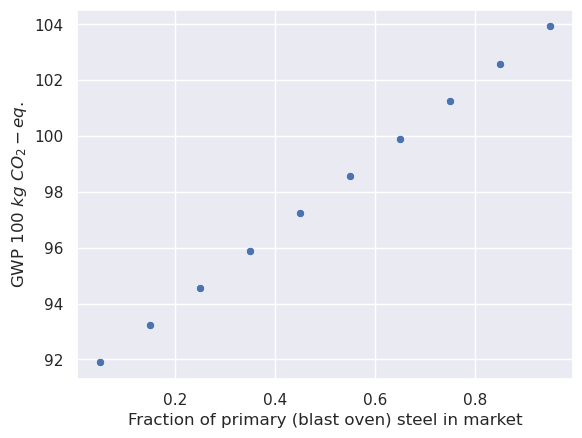

In [15]:
sb.set_theme()
sb.scatterplot(x=fractions, y=scores)
plt.xlabel("Fraction of primary (blast oven) steel in market")
plt.ylabel(r"GWP 100 $kg\ CO_{2}-eq.$")
pass

Make some changes to see differences just for cement with free fly ash

In [16]:
demand = {
    my_configuration.cement_market: 100
}   

In [17]:
fu, data_objs, remapping = bd.prepare_lca_inputs(demand=demand, method=ipcc)

In [18]:
fractions = np.linspace(0.05, 0.95, 10)
scores = []

for fraction in fractions:
    # Can't reuse object because matrix changes each time
    lca = bc.LCA(fu, data_objs = data_objs + [bo.generate_datapackage(fraction)], remapping_dicts=remapping)
    lca.lci()
    lca.lcia()  
    scores.append(lca.score)

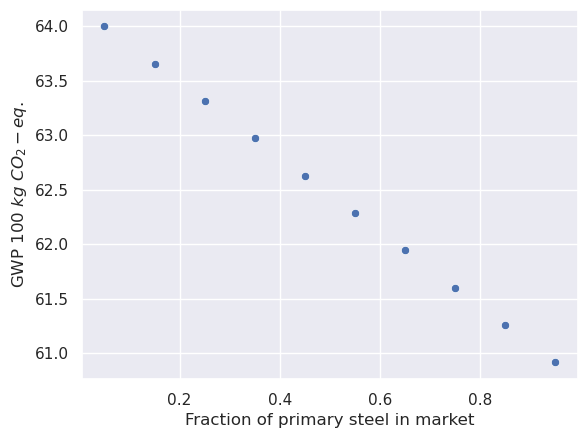

In [19]:
sb.set_theme()
sb.scatterplot(x=fractions, y=scores)
plt.xlabel("Fraction of primary steel in market")
plt.ylabel(r"GWP 100 $kg\ CO_{2}-eq.$")
pass